In [66]:
import time
import numpy as np
import pandas as pd
from datetime import datetime
from arcticdb import Arctic, QueryBuilder
import yfinance as yf
import talib

import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

True

### Connect to AWS S3 ArcticDB

In [67]:
id = os.getenv('AWS_ACCESS_KEY_ID')
key = os.getenv('AWS_SECURITY_ACCESS_KEY')

# Define your S3 bucket details
bucket_name = "lowquant-arcticdb"
region_name = "eu-central-1"
endpoint = "s3.eu-central-1.amazonaws.com"  # This is a typical endpoint format for AWS S3

# Create an Arctic instance
ac = Arctic(f's3://{endpoint}:{bucket_name}?region={region_name}&access={id}&secret={key}')


### Create a Library

In [69]:
library = ac.get_library("spx500", create_if_missing=True)

# Check if new library in ac
ac.list_libraries()

['spx500']

### Download S&P 500 Index Data and store it in the library

In [70]:
# Load S&P 500 constituents from Wikipedia
spx500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",index_col=0)[0]
symbols = spx500.index.to_list()

# Show S&P 500 wiki table
spx500.head()

,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Symbol,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [71]:
data = yf.download(symbols, group_by="Ticker", period="2y", auto_adjust=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2y)')
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


CHTR                                               \
                           Open        High         Low       Close   Volume   
Date                                                                           
2021-12-02 00:00:00  639.270020  675.520020  639.270020  670.400024  1432500   
2021-12-03 00:00:00  675.000000  681.799988  669.510010  679.299988  1336500   
2021-12-06 00:00:00  688.109985  693.090027  669.690002  672.950012   951700   
2021-12-07 00:00:00  677.840027  678.719971  639.280029  650.599976  2156200   
2021-12-08 00:00:00  650.340027  652.380005  630.150024  642.070007  1717300   

                           PYPL                                                \
                           Open        High         Low       Close    Volume   
Date                                                                            
2021-12-02 00:00:00  180.104996  188.800003  179.729996  187.149994  20422700   
2021-12-03 00:00:00  187.729996  187.800003  179.289993  183.929993  20737500   
2021-12-06 00:00:00  183.410004  186.070007  179.199997  184.860001  13303400   
2021-12-07 00:00:00  188.669998  192.828003  188.429993  191.020004  17772700   
2021-12-08 00:00:00  191.949997  197.690002  190.089996  197.350006  14433200   

                     ...         DOV                                      \
                     ...        Open        High         Low       Close   
Date                 ...                                                   
2021-12-02 00:00:00  ...  158.912948  163.013051  158.543739  161.701401   
2021-12-03 00:00:00  ...  162.245487  163.197639  159.340433  162.264908   
2021-12-06 00:00:00  ...  164.081769  165.976363  163.391935  165.160233   
2021-12-07 00:00:00  ...  167.113152  170.144502  166.433043  167.356049   
2021-12-08 00:00:00  ...  167.589238  167.589238  165.422586  166.967422   

                                     T                                   \
                     Volume       Open       High        Low      Close   
Date                                                                      
2021-12-02 00:00:00  695800  14.674960  15.320447  14.674960  15.182129   
2021-12-03 00:00:00  855200  15.162367  15.498282  15.089913  15.452176   
2021-12-06 00:00:00  525500  15.537806  15.768338  15.300688  15.333622   
2021-12-07 00:00:00  720500  15.346793  15.392899  15.129437  15.201888   
2021-12-08 00:00:00  473500  15.162368  15.524631  15.136021  15.261167   

                                
                        Volume  
Date                            
2021-12-02 00:00:00  105952835  
2021-12-03 00:00:00   93399859  
2021-12-06 00:00:00   78265347  
2021-12-07 00:00:00   82646331  
2021-12-08 00:00:00   64794044  

[5 rows x 2517 columns]

In [72]:
df = data.stack(level=0).rename_axis(['Date', 'Symbol']).reset_index(level=1)
df = df.sort_values(by='Symbol',axis='index',kind='stable').drop(axis=1,columns="Adj Close")
df.head()

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2021-12-02,A,145.937737,150.436930,145.760129,148.976669,1514100.0
2021-12-03,A,149.795640,150.959899,145.750304,147.338837,1412600.0
2021-12-06,A,147.348684,150.012679,145.809487,149.450287,1803400.0
2021-12-07,A,150.801986,154.156658,150.575057,151.749191,1422700.0
2021-12-08,A,152.696403,154.304674,151.897206,154.225739,1491500.0


In [77]:
df

,Symbol,Open,High,Low,Close,Volume,Name,Sector,Industry,ATR
Date,,,,,,,,,,
2021-12-02,A,145.937737,150.436930,145.760129,148.976669,1514100.0,Agilent Technologies,Health Care,Health Care Equipment,NaN
2021-12-03,A,149.795640,150.959899,145.750304,147.338837,1412600.0,Agilent Technologies,Health Care,Health Care Equipment,NaN
2021-12-06,A,147.348684,150.012679,145.809487,149.450287,1803400.0,Agilent Technologies,Health Care,Health Care Equipment,NaN
2021-12-07,A,150.801986,154.156658,150.575057,151.749191,1422700.0,Agilent Technologies,Health Care,Health Care Equipment,NaN
2021-12-08,A,152.696403,154.304674,151.897206,154.225739,1491500.0,Agilent Technologies,Health Care,Health Care Equipment,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-11-27,ZTS,180.029999,180.789993,178.470001,178.789993,1442700.0,Zoetis,Health Care,Pharmaceuticals,3.755021
2023-11-28,ZTS,178.110001,178.360001,176.160004,176.970001,1348900.0,Zoetis,Health Care,Pharmaceuticals,3.674662
2023-11-29,ZTS,177.869995,178.059998,175.240005,175.789993,1524400.0,Zoetis,Health Care,Pharmaceuticals,3.613614


In [73]:
# Map the sectors and industries to the df DataFrame
df["Name"] = df["Symbol"].map(spx500["Security"])
df['Sector'] = df['Symbol'].map(spx500['GICS Sector'])
df['Industry'] = df['Symbol'].map(spx500["GICS Sub-Industry"])

In [80]:
df["50D_SMA"] = df.groupby("Symbol")["Close"].rolling(window=50).mean().reset_index(level=0, drop=True)
df["200D_SMA"] = df.groupby("Symbol")["Close"].rolling(window=200).mean().reset_index(level=0, drop=True)
df['ATR'] = df.groupby('Symbol').apply(lambda group: talib.ATR(group['High'], group['Low'], group['Close'], timeperiod=14)).reset_index(level=0, drop=True)


In [81]:
df['1M'] = df.groupby('Symbol')['Close'].pct_change(21)
df['3M'] = df.groupby('Symbol')['Close'].pct_change(63)
df['6M'] = df.groupby('Symbol')['Close'].pct_change(126)
df['12M'] = df.groupby('Symbol')['Close'].pct_change(252)
df['RS IBD'] = 2*df['3M']+df['6M']+df['12M'] # IBD Relative Strength =  2x 3M + 1x 6M + 1x 12M
df['RS Rank'] = df.groupby(df.index)['RS IBD'].rank(pct=True)
df["RS Rank 20D MA"] = df.groupby("Symbol")["RS Rank"].rolling(window=20).mean().reset_index(level=0, drop=True)

#df[df.Symbol =="AAPL"][48:]

In [88]:
df

,Symbol,Open,High,Low,Close,Volume,Name,Sector,Industry,ATR_x,...,ATR,50D_SMA,200D_SMA,1M,3M,6M,12M,RS IBD,RS Rank,RS Rank 20D MA
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,A,145.937737,150.436930,145.760129,148.976669,1514100.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03,A,149.795640,150.959899,145.750304,147.338837,1412600.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-06,A,147.348684,150.012679,145.809487,149.450287,1803400.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-07,A,150.801986,154.156658,150.575057,151.749191,1422700.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-08,A,152.696403,154.304674,151.897206,154.225739,1491500.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,ZTS,180.029999,180.789993,178.470001,178.789993,1442700.0,Zoetis,Health Care,Pharmaceuticals,3.755021,...,3.755021,171.085005,173.217657,0.133789,-0.041512,0.090277,0.199049,0.206301,0.612450,0.511145
2023-11-28,ZTS,178.110001,178.360001,176.160004,176.970001,1348900.0,Zoetis,Health Care,Pharmaceuticals,3.674662,...,3.674662,171.039987,173.316170,0.136921,-0.079765,0.104659,0.189769,0.134898,0.582329,0.520181
2023-11-29,ZTS,177.869995,178.059998,175.240005,175.789993,1524400.0,Zoetis,Health Care,Pharmaceuticals,3.613614,...,3.613614,170.924880,173.384894,0.122362,-0.085569,0.083359,0.197553,0.109775,0.542169,0.527410


In [90]:
# Sort the DataFrame by the 'Date' index
df = df.sort_index()

# Now you can write the sorted DataFrame to the Arctic library
library.write("ALL_STOCKS", df)


VersionedItem(symbol='ALL_STOCKS', library='spx500', data=n/a, version=0, metadata=None, host='S3(endpoint=s3.eu-central-1.amazonaws.com, bucket=lowquant-arcticdb)')

In [92]:
library.read("ALL_STOCKS").data

,Symbol,Open,High,Low,Close,Volume,Name,Sector,Industry,ATR_x,...,ATR,50D_SMA,200D_SMA,1M,3M,6M,12M,RS IBD,RS Rank,RS Rank 20D MA
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-02,A,145.937737,150.436930,145.760129,148.976669,1514100.0,Agilent Technologies,Health Care,Health Care Equipment,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,NSC,258.841190,269.713893,257.693693,266.625183,2057300.0,Norfolk Southern Railway,Industrials,Rail Transportation,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,ADP,219.492921,224.980491,219.492921,223.375534,2121700.0,ADP,Industrials,Human Resource & Employment Services,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,NRG,33.135399,34.163069,33.042814,33.839027,2269300.0,NRG Energy,Utilities,Independent Power Producers & Energy Traders,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-02,NOW,599.570007,625.799988,598.640015,623.369995,1460000.0,ServiceNow,Information Technology,Systems Software,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,K,52.470001,52.910000,52.040001,52.880001,1957400.0,Kellanova,Consumer Staples,Packaged Foods & Meats,0.905175,...,0.905175,51.372696,58.094249,0.056512,-0.049351,-0.146311,-0.196364,-0.441376,0.122490,0.136847
2023-12-01,KDP,31.660000,32.189999,31.629999,32.169998,8212900.0,Keurig Dr Pepper,Consumer Staples,Soft Drinks & Non-alcoholic Beverages,0.523807,...,0.523807,30.710227,32.412652,0.056139,-0.034579,0.036594,-0.147383,-0.179946,0.248996,0.292470
2023-12-01,AVB,172.899994,177.979996,172.300003,177.940002,1174600.0,AvalonBay Communities,Real Estate,Multi-Family Residential REITs,3.705625,...,3.705625,170.863334,174.897256,0.085861,-0.009324,0.000334,0.057455,0.039141,0.411647,0.420281


In [13]:
# Moving Average over RS Rank to get continuous improvers
print(len(df), len(df["RS Rank"]), len(df["RS Rank 20D MA"]))

# Assuming the lengths match and indices are aligned
condition = df["RS Rank"] > df["RS Rank 20D MA"]
filtered_df = df[condition]

# Filter for a specific date
specific_date_df = filtered_df.loc[filtered_df.index == "2023-11-30"]
day_after_df = df[ ( df.Symbol.isin(specific_date_df.Symbol)  )& (df.index == "2023-12-01") ]


250893 250893 250893


In [15]:
df["RSFactor"] = np.where(condition,df['RS Rank'],0)

In [30]:
df

,Symbol,Open,High,Low,Close,Volume,Adj Close,Name,Sector,Industry,50D_SMA,1M,3M,6M,12M,RS IBD,RS Rank,RS Rank 20D MA,1D_Forward_Return,RSFactor
Date,,,,,,,,,,,,,,,,,,,,
2021-12-02,A,145.937752,150.436946,145.760144,148.976685,1514100.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010994,0.000000
2021-12-03,A,149.795594,150.959852,145.750259,147.338791,1412600.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014331,0.000000
2021-12-06,A,147.348669,150.012663,145.809472,149.450272,1803400.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015383,0.000000
2021-12-07,A,150.802016,154.156689,150.575087,151.749222,1422700.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016320,0.000000
2021-12-08,A,152.696403,154.304674,151.897206,154.225739,1491500.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010876,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,ZTS,180.029999,180.789993,178.470001,178.789993,1442700.0,NaN,Zoetis,Health Care,Pharmaceuticals,171.085005,0.133789,-0.041512,0.090277,0.199049,0.206301,0.612450,0.511145,-0.010179,0.612450
2023-11-28,ZTS,178.110001,178.360001,176.160004,176.970001,1348900.0,NaN,Zoetis,Health Care,Pharmaceuticals,171.039987,0.136921,-0.079765,0.104659,0.189769,0.134898,0.582329,0.520181,-0.006668,0.582329
2023-11-29,ZTS,177.869995,178.059998,175.240005,175.789993,1524400.0,NaN,Zoetis,Health Care,Pharmaceuticals,170.924880,0.122362,-0.085569,0.083359,0.197553,0.109775,0.542169,0.527410,0.005006,0.542169


In [37]:
import alphalens

# Preparing the factor data
factor_data = df.reset_index().set_index(['Date', 'Symbol'])['RSFactor']

# Pivot the DataFrame to make each column an asset and each row a timestamp
# pricing_data = df.reset_index().pivot(index='Date', columns='Symbol', values='Close')

# SEE HERE: https://github.com/quantopian/alphalens/blob/master/alphalens/examples/tear_sheet_walk_through.ipynb
pricing = df.reset_index().pivot(index='Date', columns='Symbol', values='Open')

ticker_sector = spx500['GICS Sector'].to_dict()
sector_names = {sector: sector for sector in spx500['GICS Sector'].unique()}


#factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_data

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(
    factor_data, 
    pricing, 
    quantiles=None,
    bins=3,
    max_loss=99
    #groupby=ticker_sector,
    #groupby_labels=sector_names
)


Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 9900.0%, not exceeded: OK!


In [38]:
factor_data

,,1D,5D,10D,factor,factor_quantile
date,asset,,,,,
2021-12-02,A,0.026435,0.058076,0.043202,0.000000,2
2021-12-03,A,-0.016335,0.017850,-0.009682,0.000000,2
2021-12-06,A,0.023437,0.053569,0.009509,0.000000,2
2021-12-07,A,0.012562,0.013413,-0.012039,0.000000,2
2021-12-08,A,0.011243,-0.012923,-0.002003,0.000000,2
...,...,...,...,...,...,...
2023-11-10,ZTS,-0.010733,0.040467,0.055833,0.550201,2
2023-11-13,ZTS,0.016185,0.033436,0.055905,0.504016,2
2023-11-14,ZTS,0.006301,0.030512,0.037687,0.000000,1


In [39]:
mean_return_by_q_daily, std_err = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)


<Axes: title={'center': 'Mean Period Wise Return By Factor Quantile'}, ylabel='Mean Return (bps)'>

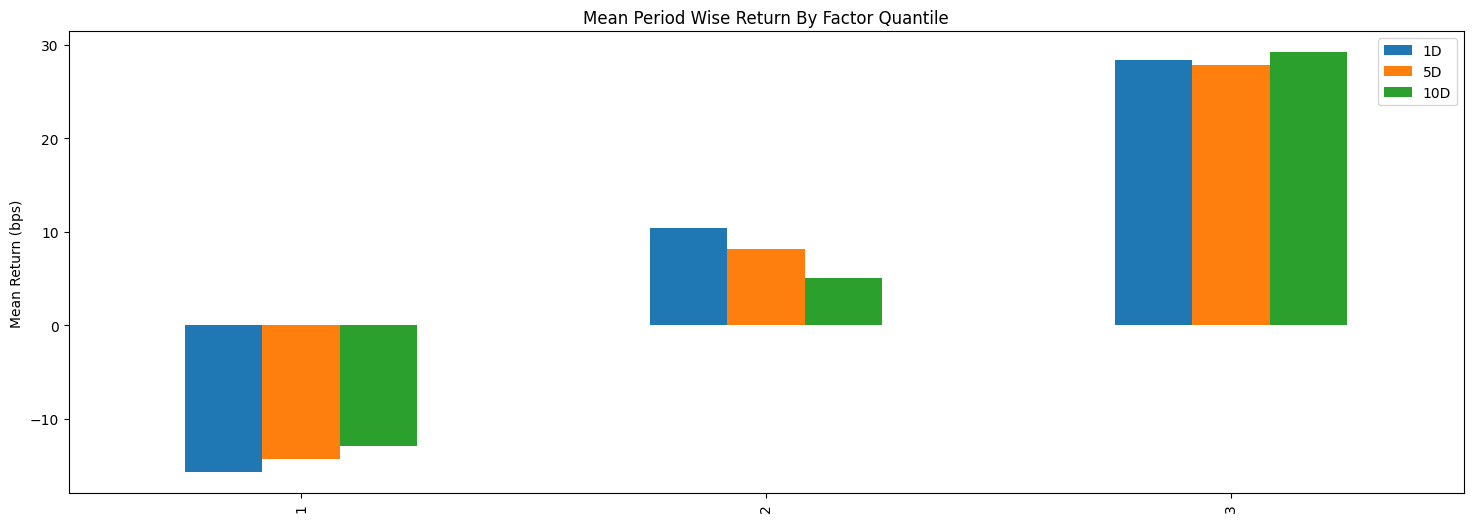

In [40]:
# mean_return_by_q_daily.head()
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=False)


alphalens.plotting.plot_quantile_returns_bar(mean_return_by_q)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.847,0.124,0.059
beta,-0.085,-0.029,-0.026
Mean Period Wise Return Top Quantile (bps),28.371,5.557,2.915
Mean Period Wise Return Bottom Quantile (bps),-15.739,-2.867,-1.288
Mean Period Wise Spread (bps),44.110,8.381,4.169


<Figure size 640x480 with 0 Axes>

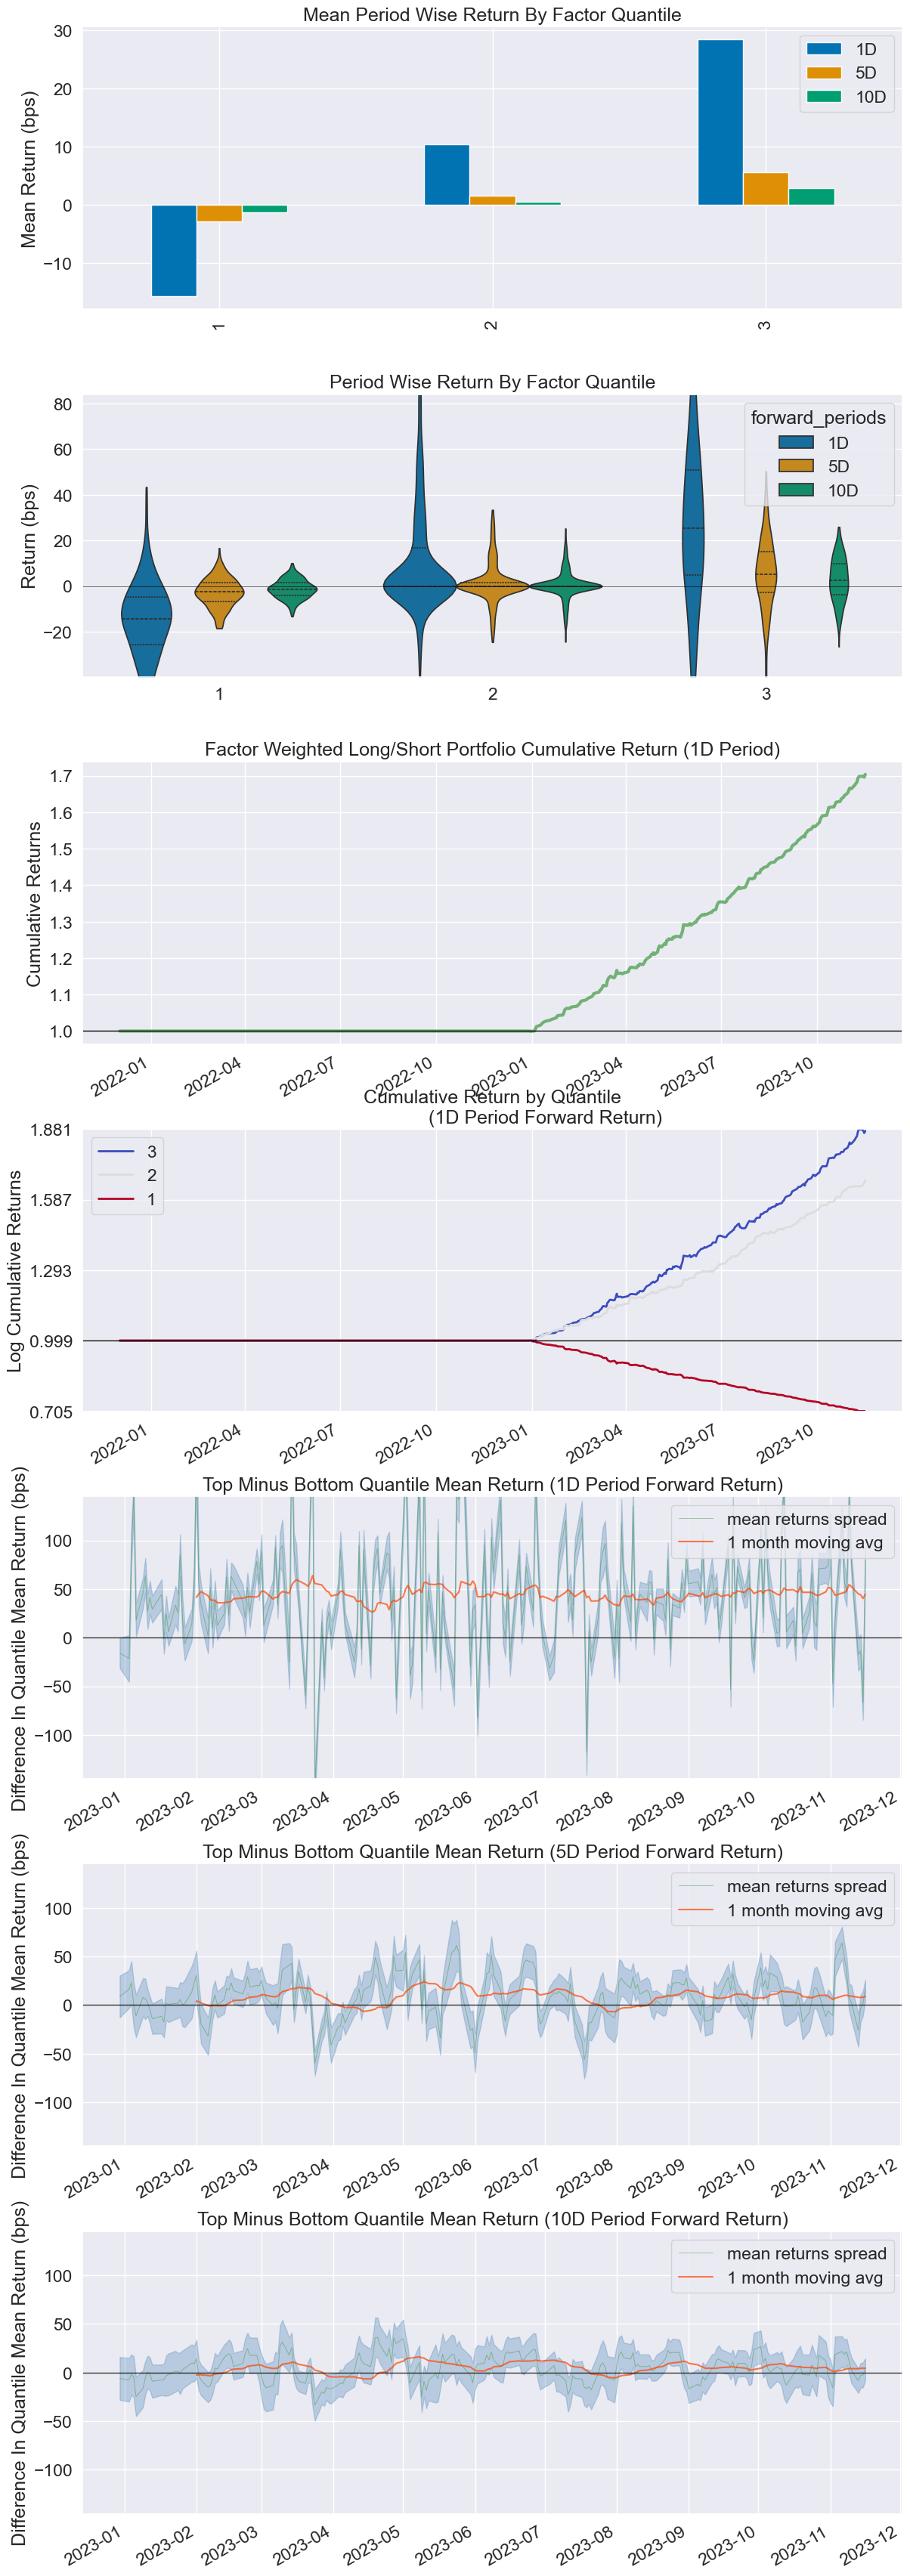

In [41]:
alphalens.tears.create_returns_tear_sheet(factor_data)


In [14]:
# Calculate 1-day forward return for the filtered data
filtered_df['1D_Forward_Return'] = (filtered_df['Close'].shift(-1) - filtered_df['Close']) / filtered_df['Close']

# Calculate 1-day forward return for the whole dataset
df['1D_Forward_Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']

# Compare the average returns
average_return_filtered = filtered_df['1D_Forward_Return'].mean()
average_return_overall = df['1D_Forward_Return'].mean()

# Printing the results
print(f"Average 1-Day Forward Return for Filtered Data: {average_return_filtered}")
print(f"Average 1-Day Forward Return for Overall Data: {average_return_overall}")

Average 1-Day Forward Return for Filtered Data: 0.01013551424788351
Average 1-Day Forward Return for Overall Data: 0.00286858088278888


/var/folders/gb/y5wbxrk56nl43nqmf6f873g40000gn/T/ipykernel_16664/1053140784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['1D_Forward_Return'] = (filtered_df['Close'].shift(-1) - filtered_df['Close']) / filtered_df['Close']


In [50]:
day_after_df.head()

,Symbol,Open,High,Low,Close,Volume,Adj Close,Name,Sector,Industry,50D_SMA,1M,3M,6M,12M,RS IBD,RS Rank,RS Rank 20D MA
Date,,,,,,,,,,,,,,,,,,
2023-12-01,A,127.339996,129.009995,126.510002,128.789993,1715286.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,112.039302,0.252090,0.058565,0.093691,-0.163119,0.047702,0.429719,0.253213
2023-12-01,AAL,12.460000,13.060000,12.445000,13.020000,48657644.0,NaN,American Airlines Group,Industrials,Passenger Airlines,12.046000,0.168761,-0.113079,-0.124412,-0.097713,-0.448283,0.120482,0.085843
2023-12-01,ABBV,142.539993,144.100006,142.280106,143.410004,4658045.0,NaN,AbbVie,Health Care,Pharmaceuticals,143.884143,0.006598,-0.022635,0.070003,-0.074305,-0.049573,0.343373,0.347390
2023-12-01,ABNB,125.500000,135.414993,125.400002,135.020004,7416668.0,NaN,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",125.163000,0.130158,0.017560,0.143656,0.321911,0.500686,0.791165,0.699598
2023-12-01,ABT,104.220001,104.980003,103.900002,104.879997,4649903.0,NaN,Abbott,Health Care,Health Care Equipment,96.592608,0.103884,0.025382,0.016952,-0.005595,0.062122,0.443775,0.346285


In [51]:
specific_date_df.head()

,Symbol,Open,High,Low,Close,Volume,Adj Close,Name,Sector,Industry,50D_SMA,1M,3M,6M,12M,RS IBD,RS Rank,RS Rank 20D MA
Date,,,,,,,,,,,,,,,,,,
2023-11-30,A,128.000000,128.449997,126.970001,127.800003,2442900.0,NaN,Agilent Technologies,Health Care,Health Care Equipment,111.653686,0.236335,0.057716,0.103580,-0.147324,0.071688,0.453815,0.237048
2023-11-30,AAL,12.330000,12.470000,12.080000,12.430000,34595600.0,NaN,American Airlines Group,Industrials,Passenger Airlines,12.046800,0.114798,-0.156144,-0.154422,-0.120934,-0.587643,0.088353,0.083635
2023-11-30,ABBV,138.009995,142.699997,138.009995,142.389999,9297400.0,NaN,AbbVie,Health Care,Pharmaceuticals,144.054132,0.008571,-0.021399,0.089700,-0.063576,-0.016673,0.381526,0.357631
2023-11-30,ABNB,127.000000,128.130005,125.084999,126.339996,5956300.0,NaN,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",125.117600,0.068053,-0.039605,0.126426,0.324596,0.371813,0.688755,0.676406
2023-11-30,ABT,103.750000,104.720001,103.110001,104.290001,16766200.0,NaN,Abbott,Health Care,Health Care Equipment,96.462716,0.103014,0.019119,0.024803,0.013108,0.076148,0.457831,0.339558


In [1]:
# pct_change =  (day_after_df["Close"] / specific_date_df["Close"]) - 1
# pct_change

# Reset index if necessary and make sure 'Symbol' is a column
day_after_df_reset = day_after_df.reset_index()
specific_date_df_reset = specific_date_df.reset_index()

# Merge the DataFrames on 'Symbol'
merged_df = pd.merge(specific_date_df_reset, day_after_df_reset, on='Symbol', suffixes=('_specific_date', '_day_after'))

# Calculate percent change
merged_df['pct_change'] = (merged_df['Close_day_after'] / merged_df['Close_specific_date']) - 1

# View the result
pct_change = merged_df['pct_change']
print(pct_change)


NameError: name 'day_after_df' is not defined

In [ ]:
last_row = df.groupby('Symbol').apply(lambda group: group.iloc[-1::]).sort_values('1M',ascending=False)

In [28]:
pan = yf.download(symbols[:10], start='2014-12-01', end='2017-07-01')
pan

[*********************100%%**********************]  10 of 10 completed


Adj Close                                                \
                 ABBV        ABT         ACN        ADBE        ADM   
Date                                                                  
2014-12-01  47.362366  37.360363   74.077156   73.750000  40.888092   
2014-12-02  47.472012  38.119049   74.059914   73.470001  41.550591   
2014-12-03  46.944336  38.506813   74.525047   73.180000  41.862350   
2014-12-04  47.677620  38.346649   74.370010   73.029999  41.137501   
2014-12-05  47.773548  38.186470   74.240814   72.400002  41.503838   
...               ...        ...         ...         ...        ...   
2017-06-26  54.554939  43.708515  110.965790  144.960007  34.545937   
2017-06-27  54.292458  43.494026  110.829727  142.539993  34.294998   
2017-06-28  54.689941  43.324238  112.235619  143.809998  34.412090   
2017-06-29  54.359943  43.547653  111.555351  141.240005  33.985500   
2017-06-30  54.382450  43.440418  112.181213  141.440002  34.612846   

                                                                    ...  \
                  ADP        AES        AFL        AOS         MMM  ...   
Date                                                                ...   
2014-12-01  70.792786  10.045612  23.859755  23.373791  116.817795  ...   
2014-12-02  70.570740  10.185441  24.000652  23.278177  118.619972  ...   
2014-12-03  70.685844  10.163363  24.032854  23.999651  119.846016  ...   
2014-12-04  70.784576  10.111844  23.924162  23.912718  119.846016  ...   
2014-12-05  70.587166  10.067690  23.956371  23.956179  119.853439  ...   
...               ...        ...        ...        ...         ...  ...   
2017-06-26  89.734390   9.440166  33.189274  50.758034  167.559769  ...   
2017-06-27  89.111076   9.294687  33.300598  50.337658  165.329346  ...   
2017-06-28  90.147034   9.157286  33.531826  50.534431  165.991348  ...   
2017-06-29  89.075928   9.019885  33.227798  50.042500  163.808319  ...   
2017-06-30  89.953880   8.979474  33.262054  50.382381  164.076324  ...   

             Volume                                                          \
               ABBV       ABT      ACN     ADBE      ADM      ADP       AES   
Date                                                                          
2014-12-01  4885100   5340400  2743600  2023300  4437600  2055000   4832800   
2014-12-02  6491500  10949300  2504300  1843600  4839100  1676100   6607800   
2014-12-03  5817700   4993000  1728400  1569100  4796000  1875800  10515900   
2014-12-04  7665300   6377200  1724400  1415200  3945200  1550900   3588100   
2014-12-05  4360100   4179500  2229900  3061700  3746500  1792000   5064700   
...             ...       ...      ...      ...      ...      ...       ...   
2017-06-26  4019500   5302600  2623000  2775500  1856900  2412600   5189400   
2017-06-27  4490600   3893200  2214800  3018900  1884700  2882200   4684300   
2017-06-28  4196200   8366300  1727500  2507900  2230200  2934100   6527700   
2017-06-29  4444700   6048500  2687300  2653900  3514700  3799800   5909300   
2017-06-30  4729100   4723300  2290300  2331000  3158500  2958600   4224400   

                                       
                AFL      AOS      MMM  
Date                                   
2014-12-01  3538200   750200  2502100  
2014-12-02  3216400  1323800  2504400  
2014-12-03  2862000   768000  3038800  
2014-12-04  2991600  1043000  2164200  
2014-12-05  3846600   421000  1722600  
...             ...      ...      ...  
2017-06-26  2683200   510100  1352100  
2017-06-27  2693400   600800  2240200  
2017-06-28  2828400   551700  1542900  
2017-06-29  3345800   546800  1809900  
2017-06-30  3041800   690300  1770000  

[651 rows x 60 columns]

TypeError: transpose() takes at most 1 argument (3 given)